Event Driven Simulation 

In [43]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [19]:
x=df['PCI Serving'].unique()

Scheduling CoMP
---------

In [275]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

SCHEDULE_T=2 #Clock des Schedulers 



def df_to_ue_lists(df,cluster,thr):

    cluster=[19,20]
    df_filter=df.groupby('PCI Serving')
    ue_dict={}
    counter=0
    for i in cluster:
        ue_list=np.array([])
        df2=df_filter.get_group(i)  
        for j in df2.index:
            ue_list=np.append(ue_list, ue(df.iloc[j]['JT_1 SINR [lin]'],df.iloc[j]['JT_2 SINR [lin]'],df.iloc[j]['PCI Serving'],df.iloc[j]['PCI Coord'],env,df.iloc[j]['usage'], thr))
        ue_dict[i]= ue_list
        counter+=1
    return ue_dict

#function to monitor the level of the different queues
def monitor(queue,monitor): 
    monitor.update({env.now: queue.level})
    return monitor

def calculate_prb_number(users,max_prb):
    count=0
    for i in np.arange(len(users)):
        count=count+users[i].comp
    prb_number=round(count/np.size(users)*max_prb)
    return prb_number

def get_dataframe(users):
    df=pd.DataFrame()
    sinr=np.array([])
    sinr2=np.array([])
    tbs=np.array([])
    queue=np.array([])
    
    for i in np.arange(np.size(users)):
        sinr=np.append(sinr,users[i].sinr)
        sinr2=np.append(sinr,users[i].sinr2)
        tbs=np.append(sinr,users[i].tbs)
        queue=np.append(sinr,users[i].queue)
    df['sinr']=sinr
    df['sinr2']=sinr2
    df['tbs']=tbs
    df['queue']=queue
    return df

def calculate_tbs(sinr,sinr2):
    sinr=int(sinr)
    sinr2=int(sinr2)
    if(sinr>30 or sinr2>30):
        print('sinr out of range')
        tbs=30
        tbs2=30
    elif(sinr<-10):
        print('sinr out of range')
        tbs=-10
        tbs2=-10
    else:
        mapping=pd.read_csv('Data/sinr-tbs-mapping.csv')
        tbs=mapping.iloc[sinr].values[1]
        tbs2=mapping.iloc[sinr2].values[1]
    return tbs,tbs2

def central_scheduler():
    x=1
    return x
#scheduler takes packets from the queues according to the capacity of each user
def scheduler(env, users, SCHEDULE_T,cluster, prb_number):
    
    counter=1 #counts the number of scheduling procedures
    alpha=-np.log10(0.01)/100
    while True: #größte Warteschlange wird auch bedient
        
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        metric=np.array([]) 
        users[0].mon= monitor(users[0].queue,users[0].mon)
        users[10].mon= monitor(users[10].queue,users[10].mon)
        users[120].mon= monitor(users[120].queue,users[120].mon)
        users[100].mon= monitor(users[100].queue,users[100].mon)
        

        for i in np.arange(np.size(users)): 
            if(users[i].qos==1 or users[i].qos==2):
                metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process 
                users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer    
            elif(users[i].qos==0):
                if(users[i].queue.level>0):
                    metric=np.append(metric,(users[i].cp/users[i].mR))
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                elif(users[i].queue.level==0):
                    metric=np.append(metric,0)
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer

        sched_user_list = (-metric).argsort() #sort UEs by metric that will be used for scheduling
        
        #print(sched_user_list)    
        #print(users[2].queue.level)
        remaining_prbs=prb_number
        
        k=0
        #print('New scheduling round')
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]
            print(sched_user)
            queue_size=users[sched_user].queue.level
            tbs=users[sched_user].tbs

            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-sched_size
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')
            #print('user:',sched_user)    
            #print('queue size before:',queue_size)
            #print('mR before:',users[sched_user].mR)
            users[sched_user].mR=users[sched_user].mR+(1/counter)*sched_size
            users[sched_user].queue.get(sched_size)
            #print('queue size after:',users[sched_user].queue.level)
            #print('mR afer:',users[sched_user].mR)
            k=k+1
        counter=counter+1
        

        
            
class ue:
    def __init__(self,sinr,sinr2,cell1,cell2,env,qos,thr):
        self.sinr=sinr
        self.sinr2=sinr2
        self.tbs,self.tbs2=calculate_tbs(sinr,sinr2)
        self.qos=qos
        self.cp=0.5*0.7*20000000*np.log2(1+np.power(10,sinr/10))/8000
        self.cp2=0.5*0.7*20000000*np.log2(1+np.power(10,sinr2/10))/8000 #division by 8000 to determine number of bits that can be transmitted per TTI (1ms)
        self.cell1=cell1
        self.cell2=cell2
        self.mR=0.1 #mittlere Rate
        self.queue=simpy.Container(env)
        self.mon={}
        self.metric=self.sinr+self.queue.level
        self.gain=self.sinr2-self.sinr
        if(self.gain >thr):
            self.comp=np.array(1)
        else:
            self.comp=np.array(0) 
        
    def rt_user(self,env):
        on_off=1
        counter=0
        start=0
        while True:
            if(start==0):
                start=1
                yield env.timeout(random.randint(0,200))
            elif(on_off==1 and counter<3000):
                self.queue.put(160) #20 bytes
                mon= monitor(self.queue,self.mon)
                #yield env.timeout(poisson.rvs(6, 1))
                #print('On Phase')
                #print(self.queue.level)
                counter=counter+20
                #print(counter)
                yield env.timeout(20) #every 20ms new packet
            elif(on_off==0):
                on_off=1

                yield env.timeout(3000) #3s no packet to be sent
            elif(on_off==1 and counter>=3000):
                on_off=0
                counter=0
                #print('change from ON-OFF')
            
    def user_packets(self,env,packet_arr):
        while True:
            #print('o-user')
            self.queue.put(2000)
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(poisson.rvs(packet_arr, 1))
            

    def streaming_user(self,env):
        while True:
            #print('o-user')
            self.queue.put(1500) #1080p-> 1.5 Mbps 
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(2)
    
    #Noch sehr vereinfacht!!!
    def sinr_variator(self,env):
        change=round(np.random.normal(0,0.5))
        if((self.sinr+change)>-10 and (self.sinr+change)<30): 
            self.sinr=self.sinr +change
            self.sinr2=self.sinr2+change 
        yield env.timeout(2000)


In [276]:
env=simpy.Environment()
#env = simpy.rt.RealtimeEnvironment(factor=1/10)

ue_list=np.array([])
ue_list2=np.array([])
#define UEs

    
max_prb=100
thr=6


x=np.append(np.ones(121)*19,np.ones(121)*20)
y=np.append(np.ones(121)*20,np.ones(121)*19)
sinr=np.random.randint(0,15,121*2)
sinr2=np.random.randint(2,18,121*2)
rt_nrt=np.append(np.ones(100)*0,np.ones(20))
rt_nrt=np.append(rt_nrt,3)
rt_nrt=np.append(rt_nrt,np.ones(100)*0)
rt_nrt=np.append(rt_nrt,np.ones(20))
rt_nrt=np.append(rt_nrt,3)

df=pd.DataFrame()
df['PCI Serving']=x
df['PCI Coord']=y
df['JT_1 SINR [lin]']=sinr
df['JT_2 SINR [lin]']=sinr2
df['usage']=rt_nrt
   
df['PCI Serving']=df['PCI Serving'].astype('int')
df['PCI Coord']=df['PCI Coord'].astype('int')

df['JT_1 SINR [lin]']=df['JT_1 SINR [lin]'].astype('int')
df['JT_2 SINR [lin]']=df['JT_2 SINR [lin]'].astype('int')


ue_dict=df_to_ue_lists(df,[19,20],6)
ue_all=np.array([])
for i in cluster:
    ue_all=np.append(ue_all,ue_dict[i])

prb_number_comp=calculate_prb_number(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp
        

In [277]:
#Start processes
for i in cluster:
    ue_list=ue_dict[i]
    env.process(scheduler(env,ue_list,SCHEDULE_T,['19','18'],prb_number_normal))
    for i in np.arange(0,100):
        env.process(ue_list[i].user_packets(env,500))
        #env.process(ue_list[i].sinr_variator()) #movement
    env.process(ue_list[100].streaming_user(env))
    #env.process(ue_list[100].sinr_variator()) #movement   
    for i in np.arange(101,121):
        env.process(ue_list[i].rt_user(env))
        #env.process(ue_list[i].sinr_variator()) #movement


env.run(until=3000)

100
23
29
88
34
100
83
66
4
36
35
0
73
0
73
59
59
68
49
70
47
67
48
98
97
67
66
94
64
96
65
64
46
65
63
47
68
92
94
60
43
60
46
63
62
45
92
56
55
99
61
96
45
61
58
91
56
55
44
95
57
90
54
53
103
54
53
52
44
58
57
95
43
37
86
86
35
40
37
38
39
42
36
38
41
33
34
97
84
32
81
31
32
41
33
80
84
30
83
30
79
87
29
82
116
80
31
79
69
26
40
28
78
25
51
81
26
27
77
24
71
99
91
93
23
27
25
76
69
24
78
85
39
22
72
20
98
21
75
70
88
19
20
85
87
74
76
93
89
50
82
77
75
51
21
48
49
90
71
18
89
52
50
16
107
109
110
74
117
19
28
13
14
22
62
10
18
13
102
106
17
112
15
14
118
12
11
12
1
2
3
11
101
107
42
10
72
17
105
9
8
9
8
1
2
4
108
3
5
5
6
6
7
113
7
100
16
15
100
100
117
100
113
100
100
105
100
100
100
102
103
100
101
106
100
116
100
100
111
105
100
102
107
5
114
100
119
100
112
113
100
108
55
95
107
118
100
102
107
100
110
100


<ipython-input-275-1048cb5c9651>:98: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,(users[i].cp/users[i].mR))
<ipython-input-275-1048cb5c9651>:94: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process
<ipython-input-275-1048cb5c9651>:94: RuntimeWarning: invalid value encountered in double_scalars
  metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process


17
50
96
100
113
95
100
105
106
100
10
15
112
100
104
101
51
97
71
105
100
35
39
53
100
32
29
102
100
30
88
2
111
113
100
100
64
73
114
103
100
116
119
71
62
29
109
100
108
107
100
20
27
60
29
107
100
102
96
29
103
110
116
100
115
100
9
7
15
115
117
78
113
15
49
100
105
106
100
45
112
118
100
104
101
85
105
102
100
100
76
116
34
100
92
111
113
79
18
100
98
114
100
117
116
119
26
63
118
109
100
108
107
100
67
73
28
68
119
107
109
66
91
102
100
5
68
103
110
100
115
100
68
29
115
117
11
50
113
100
74
12
100
105
106
100
86
2
112
87
68
6
104
101
100
45
101
105
102
100
111
100
49
76
116
62
33
100
98
108
111
113
100
112
100
2
106
114
3
117
116
119
100
95
63
118
100
108
107
100
82
12
85
119
107
109
52
38
102
100
29
103
110
100
115
100
92
115
117
73
58
55
113
100
85
76
100
109
105
106
100
45
76
112
30
104
101
100
98
2
29
76
83
empty queue
101
105
102
27
100
111
100
0
empty queue
116
37
118
103
100
84
empty queue
108
111
113
100
112
100
0
empty queue
106
114
51
78
117
116
119
100
84
empty queue


116
100
103
118
100
63
104
111
113
108
99
54
112
15
114
106
100
117
116
119
94
80
118
60
38
114
108
100
107
0
107
109
119
100
110
102
91
97
61
20
16
103
110
32
28
115
100
12
115
117
100
113
74
47
10
106
105
109
100
5
112
100
104
101
86
105
101
102
0
111
100
67
26
55
116
63
52
24
45
69
100
103
118
80
43
64
29
104
111
113
108
100
112
100
45
114
106
38
54
117
116
119
98
118
100
114
108
107
100
92
107
109
119
28
22
110
102
76
103
110
100
115
100
85
115
117
59
113
2
100
106
105
109
100
82
112
4
104
101
3
16
63
105
101
102
22
111
100
0
29
116
100
103
118
5
104
111
113
108
10
79
112
100
92
114
106
100
117
116
119
55
12
118
54
41
8
114
108
107
100
62
49
45
107
109
119
100
110
102
85
103
110
3
115
100
98
115
117
100
113
45
18
106
105
109
100
63
76
112
13
104
101
29
105
101
102
100
111
100
2
116
55
103
118
86
68
15
82
104
111
113
108
100
112
100
74
7
114
106
79
100
117
116
119
82
92
118
33
114
108
107
100
7
76
107
109
119
100
110
102
98
103
110
78
115
100
12
76
115
117
100
113
85
91
106
105
109


10
56
72
104
111
113
108
9
109
100
112
65
39
71
114
106
20
100
119
117
116
100
0
118
100
114
108
6
107
50
107
119
2
109
62
110
25
27
102
80
103
110
65
57
100
115
100
26
117
115
100
113
72
0
92
54
100
106
105
109
61
64
112
100
104
101
41
100
50
105
101
102
72
45
111
30
60
71
116
44
49
100
103
34
118
33
80
71
64
104
111
113
100
112
100
94
114
106
52
108
24
100
117
116
119
50
15
118
100
114
108
107
68
107
109
119
97
62
110
84
102
69
100
103
110
12
39
100
115
100
7
46
115
100
113
89
16
5
117
69
45
62
106
105
24
109
63
112
88
11
100
104
101
100
0
94
26
105
101
102
100
111
64
55
26
12
116
63
60
103
79
118
100
86
104
111
113
108
100
112
95
114
106
28
10
117
116
77
119
100
86
118
100
42
114
108
107
100
5
107
109
119
47
110
102
82
12
103
110
100
115
100
15
115
117
38
113
7
3
5
100
106
105
109
100
16
12
112
0
21
104
101
63
86
105
101
102
32
111
100
68
5
116
100
103
118
92
104
111
113
108
62
10
112
8
100
114
93
106
100
117
116
119
76
118
21
100
114
108
107
100
45
107
109
119
100
110
102
85
103
11

110
59
102
107
3
103
110
76
100
115
48
44
20
115
117
100
113
36
37
100
20
62
55
106
105
109
20
96
43
112
100
104
101
41
56
100
105
101
69
102
55
111
46
57
26
116
79
91
103
21
118
22
28
104
111
113
34
17
49
112
18
93
100
114
87
106
92
24
65
117
116
119
28
100
19
65
52
108
114
52
51
107
96
83
68
71
110
10
102
67
100
103
67
110
16
66
100
115
40
100
107
51
64
80
115
100
113
58
75
64
58
72
26
100
106
105
109
64
26
112
100
104
101
6
100
105
101
23
2
109
71
111
72
82
116
85
100
103
88
118
47
100
104
111
113
108
81
100
112
91
100
63
114
106
100
53
117
116
80
118
15
9
94
108
114
119
107
0
107
119
42
100
110
102
100
80
0
68
103
110
100
115
55
49
117
115
109
41
63
113
87
42
100
3
100
106
25
105
27
109
7
112
40
63
24
94
104
101
100
63
105
101
102
45
100
111
32
61
116
43
100
103
35
118
69
100
104
111
113
77
5
112
61
49
114
106
100
117
116
119
100
82
118
94
108
71
100
84
34
108
114
107
68
107
109
119
100
110
102
100
7
103
12
110
57
60
115
39
60
3
12
115
89
100
113
100
5
53
117
100
106
89
105
30
109


112
51
104
101
90
100
95
105
101
102
4
111
81
95
29
116
4
100
103
118
56
100
29
104
111
113
108
51
100
112
38
29
100
86
empty queue
114
87
106
50
117
116
119
15
1
118
50
100
99
108
114
20
107
100
107
84
109
49
119
110
102
100
15
85
empty queue
103
110
19
70
115
73
100
34
75
115
117
100
113
9
100
0
empty queue
100
106
105
109
31
100
76
empty queue
112
97
70
100
104
101
100
85
empty queue
105
101
102
100
111
100
0
empty queue
116
80
100
103
118
54
85
104
111
113
65
108
55
36
112
100
85
114
106
63
100
117
116
119
85
118
18
83
108
114
107
100
85
107
56
119
109
41
110
48
102
85
103
110
16
69
100
115
59
96
115
100
113
23
100
96
85
79
117
41
100
106
105
17
93
109
52
112
29
100
104
101
52
64
105
101
82
102
100
111
21
70
100
78
31
116
100
103
118
11
94
104
111
113
92
72
108
59
112
51
78
114
106
66
59
46
117
116
100
119
94
7
24
118
100
108
114
107
94
78
64
74
107
83
109
119
100
110
102
6
100
12
103
110
100
115
57
0
12
115
62
117
64
113
35
53
26
100
106
37
105
109
100
67
112
21
64
104
101
18
65
5

112
29
114
106
100
0
empty queue
14
117
116
119
100
29
118
100
86
empty queue
108
114
107
29
107
109
119
100
85
empty queue
110
102
100
29
103
110
100
0
empty queue
115
29
100
86
empty queue
115
117
100
0
empty queue
113
100
0
empty queue
100
0
empty queue
106
105
109
100
0
empty queue
112
100
0
empty queue
104
101
100
85
empty queue
105
101
27
102
100
0
empty queue
111
73
100
116
41
100
0
empty queue
103
118
13
100
104
111
113
76
108
35
112
100
0
empty queue
114
106
35
50
117
116
119
100
85
empty queue
118
50
100
108
114
107
100
0
empty queue
107
109
119
100
110
102
9
97
103
110
74
94
63
115
100
95
115
63
117
70
113
95
100
70
100
106
105
109
100
0
empty queue
112
61
98
100
104
101
36
100
0
empty queue
105
101
102
100
111
66
100
0
empty queue
116
1
4
103
118
100
85
empty queue
104
111
113
87
65
49
112
90
20
100
114
106
19
108
49
100
48
81
117
116
51
68
118
100
99
108
114
51
119
107
100
107
109
119
100
110
102
56
100
0
empty queue
103
110
80
59
115
100
0
empty queue
84
115
117
100
113
1

105
101
102
100
0
empty queue
111
13
100
116
36
100
0
empty queue
103
118
100
85
empty queue
104
111
113
108
100
0
empty queue
112
100
0
empty queue
114
106
100
0
empty queue
117
116
119
100
85
empty queue
118
100
86
empty queue
108
114
107
100
0
empty queue
107
109
119
100
85
empty queue
110
102
100
0
empty queue
103
110
100
0
empty queue
115
100
0
empty queue
115
117
100
0
empty queue
113
100
0
empty queue
100
0
empty queue
106
4
105
109
100
0
empty queue
112
100
0
empty queue
104
101
100
85
empty queue
105
101
102
35
100
111
73
100
116
100
0
empty queue
103
118
100
85
empty queue
104
111
113
108
100
0
empty queue
112
14
100
0
empty queue
114
106
27
100
0
empty queue
99
117
116
119
100
85
empty queue
63
118
100
108
114
107
100
0
empty queue
107
109
119
100
85
empty queue
110
102
100
0
empty queue
103
110
41
100
85
empty queue
115
100
0
empty queue
115
117
100
0
empty queue
113
85
100
0
empty queue
106
105
109
100
85
112
100
0
empty queue
104
101
85
105
101
94
102
100
111
100
85
0
emp

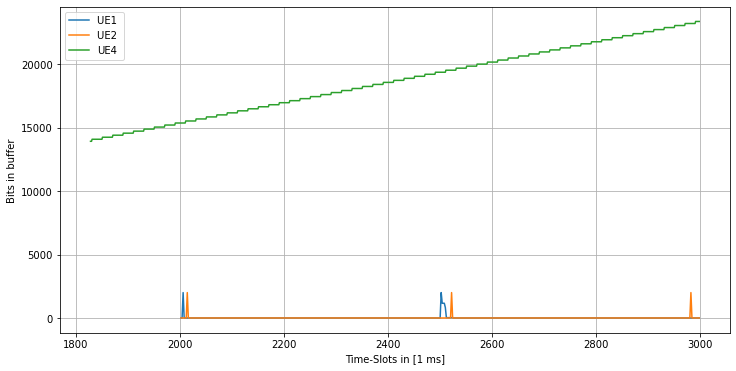

In [278]:
plt.figure(figsize=(12,6))
plt.plot(list(ue_list[0].mon.keys())[1000:3000],list(ue_list[0].mon.values())[1000:3000],label='UE1 ')
plt.plot(list(ue_list[10].mon.keys())[1000:3000],list(ue_list[10].mon.values())[1000:3000],label='UE2 ')
#plt.plot(list(ue_list[100].mon.keys())[1000:3000],list(ue_list[100].mon.values())[1000:3000],label='UE3 - ')
plt.plot(list(ue_list[120].mon.keys())[1000:3000],list(ue_list[120].mon.values())[1000:3000],label='UE4')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

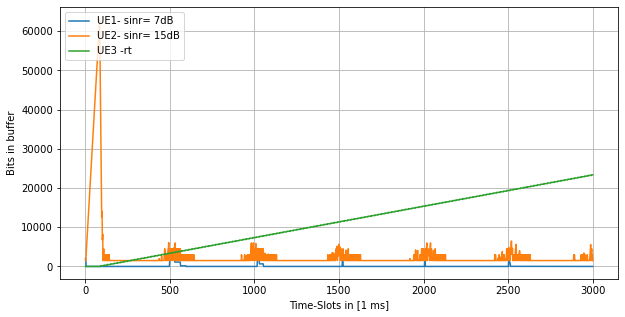

In [279]:
ue_list=ue_dict[20]
plt.figure(figsize=(10,5))
plt.plot(ue_list[0].mon.keys(),ue_list[0].mon.values(),label='UE1- sinr= 7dB')
plt.plot(ue_list[100].mon.keys(),ue_list[100].mon.values(),label='UE2- sinr= 15dB')
plt.plot(ue_list[120].mon.keys(),ue_list[120].mon.values(),label='UE3 -rt')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

#Erklärung für high peaks am anfang -> am ANfang werden alle Prozesse gleichzeitig "aktiviert" ->viele Pakete entstehen zur gleichen Zeit